# Contents:

- Description of Baum Welch Algorithm
- Implementation of Baum Welch
- Visualise EM on Generated Data
- Learning the Switch Points
- Testing Mean Field SSM on Generated Data

# Direct Implementation of Expectation Maximisation and Baum Welch on single HMM

### Baum Welch Algorithm for MLE on HMM

A time-series data is generated as a response vector $\bar{\mathbf{y}}$ that contains the water levels for each biome at any given time. The total water in the system is fixed at a constant $L$ and the system has feedback loops dictating where the water can be routed to. The response vector is an auto-regressive system that contains variables that are dependent upon one another and are dependent one their histories. An initial and general implementation can model this system as a markov chain where the water levels in the biomes are noisy observations from a state vector that tracks the true water level. $\mathbf{X_t}$ denotes the water in each biome at time step $t$ (i.e. the state of the system at time $t$). $\bar{\mathbf{y_t}}$ denotes the observed water levels at time $t$. 

We assume the first order Markov property in that the system state at time $t$ depends only on the system state at time $t-1$ plus system noise. Moreover, the output response at time $t$ depends on the system state at time $t$ plus some observation noise. 

Note that for this discussion I have followed the notation and derivation given by Shumway and Stoffer *[Schlittgen, R., 2008. Robert H. Shumway and David S. Stoffer: Time series analysis and its applications with R examples, 2nd edn. AStA Advances in Statistical Analysis, 92(2), pp.233–234.]*

We have the follow state representation for the system:

$$
\mathbf{X_t} = \Phi\mathbf{X_{t-1}} + w_t \\
\mathbf{y_t} = A\mathbf{X_t} + v_t
$$

In the case of Connected Worlds, the system noise is capturing the intuition that the users are following a plan but the specific actions are an imperfect attempt at following the plan. Moreover, the system itself is not entirely controllable in that the water has a 'spraying' nature and thus a perfect action may still result in an imperfect response.

Note that in the general case, we may choose to extend this system to the following representation:
$$
\mathbf{X_t} = \Phi\mathbf{X_{t-1}} + \Upsilon u_t + w_t \\
\bar{\mathbf{y_t}} = A\mathbf{X_t} + \Gamma u_t + v_t
$$

The intuition is that we have decomposed the state and observation transitsions into further representations that depends on the user actions. For now we assume that A = I (i.e. the states are directly observed in the simulation without any observation noise). Moreover, we assume that the state transitsion matrix $\Phi$ is constant for a specific plan. Lastly, for an initial implementation, the state transitsion noise $w_t$ is a normal random varible wiht mean 0 and variance covariance matrix $R$. For convenience, I have included the observation noise $v_t \sim \mathcal{N}(0, \mathbf{Q})$, with variance-covariance matrix $\mathbf{Q}$ so as not to repeat calculations when we choose to include this variable. For the initial implementation, we set $\mathbf{Q} = \mathbf{0}$. 

Different to the trivial maximum likelihood approach pursued that is found [here](https://github.com/NickHoernle/Essil/blob/master/baseline_model/switching-state-space-model.ipynb), we follow the Baum-Welch expectation maximisation approach that guarantees that the log-likelihood of the data is always increasing.

<hr />
<hr />

We define the first state as $\mathbf{X_t} \sim \mathcal{N}(\mu_0, \Sigma_0)$. Then, given the parameters in $\Phi$ we are able to calculate the Complete Data Likelihood from $\{ \mathbf{X_{0:n}}, \mathbf{y_{1:n}} \}$:

$$
p_\Theta (\mathbf{X_{0:n}}, \mathbf{y_{1:n}}) = p_{\mu_0, \Sigma_0}(\mathbf{X_0}) \prod\limits_{t=1}^{n} p_{\Phi, \mathbf{Q}} ( \mathbf{X_t} \vert \mathbf{X_{t-1}} )  p_{R} (  \mathbf{y_t} \vert  \mathbf{X_t} )  
$$

Using the Gaussian assumptions that are given above, and ignoring constants, we have the complete data negative log-likelihood:

$$
-2 L_{X,Y}(\Theta) = ln( \vert \Sigma_0 \vert ) + (X_0 - \mu_0)^T\Sigma_0^{-1}(X_0 - \mu_0)
+ n ln(\vert Q \vert ) + \sum\limits_{t=1}^{n} (X_t - \Phi X_{t-1})^T Q^{-1} (X_t - \Phi X_{t-1})
+ n ln(\vert R \vert ) + \sum\limits_{t=1}^{n} (y_t - A X_{t})^T R^{-1} (y_t - A X_{t})
$$

Note that we do not know the parameters $\Theta = \{ Q, R, \Phi, A \}$ and thus we do not have the complete data likelihood as specified above. If we did, finding the MLE would have been trivial. Rather, let's consider the conditional expectation of the likelihood, given a guess of the parameters $\Theta^{(j-1)}$.

$$
\mathcal{Q}( \Theta \vert \Theta^{(j-1)} = E \left\{ -2 L_{X,Y}(\Theta) \vert y_{1:n},\Theta^{(j-1)} \right\}
$$

The conditional expectations can then be derived as the Kalman Smoothers:

$$
\mathcal{Q}( \Theta \vert \Theta^{(j-1)} =  \ln( \vert \Sigma_0 \vert ) + tr \left \{ \Sigma_0^{-1} [P_0^n + (X_0^n - \mu_0)(X_0^n - \mu_0)^T \right \} 
+ n ln(\vert Q \vert ) + tr \left \{ Q^{-1} [S_{11} - S_{10} \Phi^T - \Phi S_{10}^T + \Phi S_{00} \Phi^T \right \} 
+ n ln(\vert R \vert ) + tr \left \{ R^{-1} \sum\limits_{t=1}^{n} [(y_t - AX_t^n)(y_t - AX_t^n)^T + A P_t^n A^T]  \right \}
$$

Note that it is important to see that these smoothers are calculated under the current value of the parameters $\Theta^{(j-1)}$. The overall procedure can be regarded as simply alternating between the Kalman filtering and smoothing recursions and the multivariate normal maximum likelihood estimators.

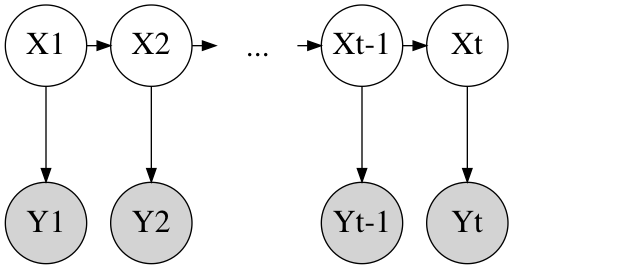

In [758]:
# g.node('B', '<<B>X<SUB>t</SUB></B>>')
# g.node('L', 'Sir Lancelot the Brave')

# g.edges(['AB', 'AL'])
# g.edge('B', 'L', constraint='false')
# g.render()  
import pydotplus as pydot
from IPython.display import Image

dot_object = pydot.Dot(graph_name='graph_1', rankdir="D", labelloc='b', labeljust='r', ranksep=1)
dot_object.set_node_defaults(shape='circle', fixedsize='true', height=.85, width=.85, fontsize=24)

plate_k = pydot.Subgraph(graph_name='plate_k', label=' ', rankdir='LR', rank='same', ranksep=3, fontsize=24, penwidth=0)
plate_m = pydot.Subgraph(graph_name='plate_m', label=' ', rankdir='LR', rank='same', ranksep=3, fontsize=24, penwidth=0)

# add the states
node_t = pydot.Node(name="xt", label=r"<<b>X<sup>t</sup></b>>")
node_tmin1 = pydot.Node(name='tmin1', label='<<B>X<SUB>t-1</SUB></B>>')
node_3 = pydot.Node(name='...', label='...', penwidth=0)
node_2 = pydot.Node(name='x2', label='<<B>X<SUB>2</SUB></B>>')
node_1 = pydot.Node(name='x1', label='<<B>X<SUB>1</SUB></B>>')

plate_m.add_node(node_t)
plate_m.add_node(node_tmin1)
plate_m.add_node(node_3)
plate_m.add_node(node_2)
plate_m.add_node(node_1)

plate_m.add_edge(pydot.Edge(node_1, node_2))
plate_m.add_edge(pydot.Edge(node_2, node_3))
plate_m.add_edge(pydot.Edge(node_3, node_tmin1))
plate_m.add_edge(pydot.Edge(node_tmin1, node_t))

# add the response variables

resp_1 = pydot.Node(name='y1', label='<<B>Y<SUB>1</SUB></B>>', style='filled', fillcolor='lightgray')
resp_2 = pydot.Node(name='y2', label='<<B>Y<SUB>2</SUB></B>>', style='filled', fillcolor='lightgray')
resp_dummie = pydot.Node(name=' ', label=' ', penwidth=0)
resp_3 = pydot.Node(name='y3', label='<<B>Y<SUB>t-1</SUB></B>>', style='filled', fillcolor='lightgray')
resp_4 = pydot.Node(name='y4', label='<<B>Y<SUB>t</SUB></B>>', style='filled', fillcolor='lightgray')

plate_k.add_node(resp_1)
plate_k.add_node(resp_2)
plate_k.add_node(resp_dummie)
plate_k.add_node(resp_3)
plate_k.add_node(resp_4)

dot_object.add_edge(pydot.Edge(node_1, resp_1))
dot_object.add_edge(pydot.Edge(node_2, resp_2))
dot_object.add_edge(pydot.Edge(node_tmin1, resp_3))
dot_object.add_edge(pydot.Edge(node_t, resp_4))

dot_object.add_subgraph(plate_k)
dot_object.add_subgraph(plate_m)

dot_object.write_png('graph.png', prog='dot')
Image('graph.png')
# dot_object.render()
# dot_object

In [759]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import theano as T
import theano.tensor as tt
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
from scipy import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning) 

import pymc3 as pm
import scipy as sp

## Kalman Filter

In [760]:
def BuildPhi(theta):
    
    Phi = np.eye(N) + np.concatenate([[[j] for j in theta[0:5]] for i in range(N)], axis=1)
    Phi = Phi/np.sum(Phi, axis=0) 
    
    return Phi

def KalmanFilterUpdate(y_t, x_tmin1_tmin1, P_tmin1_tmin1, Phi, Q, R):

    # ii - we need the forward Kalman Filter
    x_t_tmin1 = Phi.dot(x_tmin1_tmin1)
    P_t_tmin1 = Phi.dot(P_tmin1_tmin1).dot(Phi.T)
    P_t_tmin1[0:N, 0:N] += Q
    
    sigma_t = A.dot(P_t_tmin1).dot(A.T) + R
    sigma_t_inv = np.linalg.pinv(sigma_t)
    
    K_t = P_t_tmin1.dot(A.T).dot(sigma_t_inv)
    
    epsilon_t = y_t - (A.dot(x_t_tmin1)) # checked

    x_t_t = x_t_tmin1 + K_t.dot(epsilon_t)
    P_t_t = (np.eye(N) - K_t.dot(A)).dot(P_t_tmin1)
    
    return {
        "x_t_t" : x_t_t,
        "x_tmin1_t" : x_t_tmin1,
        "P_t_t" : P_t_t,
        "P_tmin_t" : P_t_tmin1,
        "Sig_t_inv" : sigma_t_inv,
        "Sig_t" : sigma_t,
        "Innovation_t" : epsilon_t,
        "K_t": K_t
        }


def ForwardKalmanFilter(ys, mu0, Sig0, Phi, Q, R):
    
    x_tmin1_tmin1 = mu0
    P_tmin1_tmin1 = Sig0
    
    Xs = np.zeros((len(ys) + 1, len(x_tmin1_tmin1)))
    Ps = np.zeros((len(ys) + 1, P_tmin1_tmin1.shape[0], P_tmin1_tmin1.shape[1]))
    X_smin1_s = np.zeros((len(ys) + 1, len(x_tmin1_tmin1)))
    P_smin1_s = np.zeros((len(ys) + 1, P_tmin1_tmin1.shape[0], P_tmin1_tmin1.shape[1]))

    
    Xs[0] = x_tmin1_tmin1
    Ps[0] = P_tmin1_tmin1
    X_smin1_s[0] = x_tmin1_tmin1
    P_smin1_s[0] = P_tmin1_tmin1
    
    incomplete_likelihood = 0
    
    for i, yt in enumerate(ys):
        
        param_update = KalmanFilterUpdate(
                y_t = yt,
                x_tmin1_tmin1 = Xs[i],
                P_tmin1_tmin1 = Ps[i],
                Phi = Phi,
                Q = Q,
                R = R
            )
        x_t_t = param_update['x_t_t']
        P_t_t = param_update['P_t_t']
        
        x_tmin1_t = param_update['x_tmin1_t']
        P_tmin1_t = param_update['P_tmin_t']
        
        Xs[i+1] = x_t_t
        Ps[i+1] = P_t_t
        X_smin1_s[i+1] = x_tmin1_t
        P_smin1_s[i+1] = P_tmin1_t
        
        incomplete_likelihood += 0.5 * np.log(np.linalg.det(param_update['Sig_t']))
        incomplete_likelihood += 0.5 * np.log(param_update['Innovation_t'].T.dot(param_update['Sig_t_inv']).dot(param_update['Innovation_t']))
        
    return {
        "Xs": Xs,
        "Ps": Ps,
        "X_smin1_s":X_smin1_s,
        "P_smin1_s":P_smin1_s,
        "Kn": param_update['K_t'],
        "incomplete_likelihood": incomplete_likelihood
    }    

In [761]:
water = [np.array([1,0,0,0,0])]
N = 5
timesteps = np.arange(1,5*60)
A = np.eye(5)

Phi = 25*np.eye(N) + np.concatenate([[[.5],[.05],[.1],[.2],[.05]] for i in range(N)], axis=1)
Phi = Phi/np.sum(Phi, axis=0) 

for i in timesteps:
    
    delta = Phi + np.random.normal([0,0,0,0,0], 0.004*np.ones(N))
    delta = delta/np.sum(delta, axis=0)       
    water.append(A.dot(delta.dot(water[i-1])))
    
water = np.array(water)
water_sim = water
Phi_real = Phi

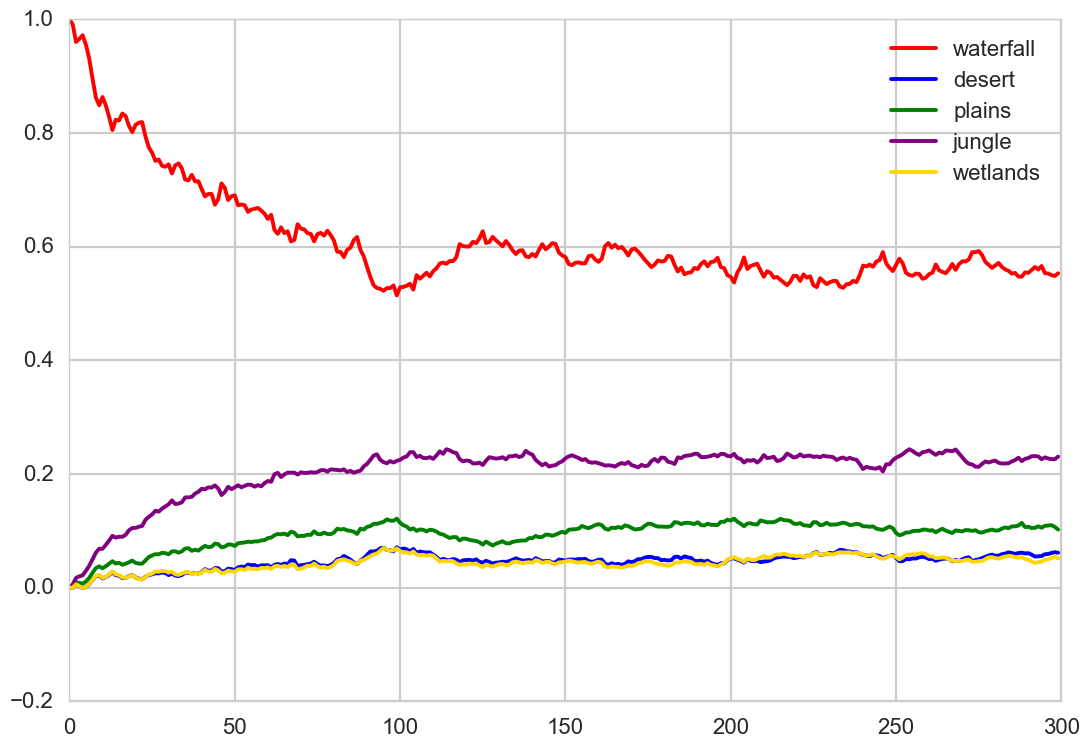

In [762]:
fig, ax = plt.subplots(1,1)

c = ['r', 'b', 'g', 'purple', 'gold']
labels=['waterfall', 'desert', 'plains', 'jungle', 'wetlands']
for i in range(len(water[0])):
    ax.plot(water[:,i], label=labels[i], c=c[i])

plt.legend(loc='best')
plt.show()

In [763]:
# test the filter:
ys = water_sim
mu0 = np.array([1,0,0,0,0])
Sig0 = np.eye(len(mu0)) * 1e-2
Q = np.eye(len(mu0)) * 1e-2
R = np.eye(len(mu0)) * 1e-5

fwd_params = ForwardKalmanFilter(ys, mu0, Sig0, Phi, Q, R)
fwd_params.keys()

dict_keys(['P_smin1_s', 'Xs', 'X_smin1_s', 'Kn', 'Ps', 'incomplete_likelihood'])

## Kalman Smoother

In [764]:
def SmootherUpdate(x_n_t, P_n_t, t, Phi, fwd_params):
    
    x_tmin1_tmin1 = fwd_params['Xs'][t-1]
    x_tmin1_t = fwd_params['X_smin1_s'][t]
    
    P_tmin1_tmin1 = fwd_params['Ps'][t-1]
    P_tmin1_t = fwd_params['P_smin1_s'][t]
    
    J_tmin1 = P_tmin1_tmin1.dot(Phi.T).dot(np.linalg.pinv(P_tmin1_t))
    x_n_tmin1 = x_tmin1_tmin1 + J_tmin1.dot(x_n_t - x_tmin1_t)    
    P_n_tmin1 = P_tmin1_tmin1 + J_tmin1.dot( P_n_t - P_tmin1_t).dot(J_tmin1.T)
    
    return {
        "x_n_tmin1": x_n_tmin1,
        "P_n_tmin1": P_n_tmin1,
        "J_tmin1" : J_tmin1
    }

In [765]:
def KalmanSmoother(fwd_params, Phi):
    
    n = len(fwd_params["Xs"])
            
    x_n_n = fwd_params["Xs"][-1]
    P_n_n = fwd_params["Ps"][-1]
        
    Xn = np.zeros((n, len(x_n_n)))
    Pn = np.zeros((n, P_n_n.shape[0], P_n_n.shape[1]))
    Jn = np.zeros((n, P_n_n.shape[0], P_n_n.shape[1]))
    
    Xn[-1] = x_n_n
    Pn[-1] = P_n_n
    
    for t in range(n-1, 0, -1):

        smt_update = SmootherUpdate(x_n_n, P_n_n, t, Phi, fwd_params)
        
        x_n_n = smt_update["x_n_tmin1"]
        P_n_n = smt_update["P_n_tmin1"]
        
        Xn[t] = x_n_n
        Pn[t] = P_n_n
        Jn[t] = smt_update["J_tmin1"]
        
    return {
        "Xn": Xn,
        "Pn": Pn,
        "Jn": Jn
    }

In [766]:
bkwd_params = KalmanSmoother(fwd_params, Phi)
bkwd_params["Xn"][1], fwd_params['Xs'][1]

(array([  1.00777074e+00,  -9.08260049e-04,  -1.87267095e-03,
         -3.80149284e-03,  -9.08260053e-04]),
 array([  9.99992067e-01,   1.05400877e-06,   2.05314594e-06,
          4.05142028e-06,   1.05400877e-06]))

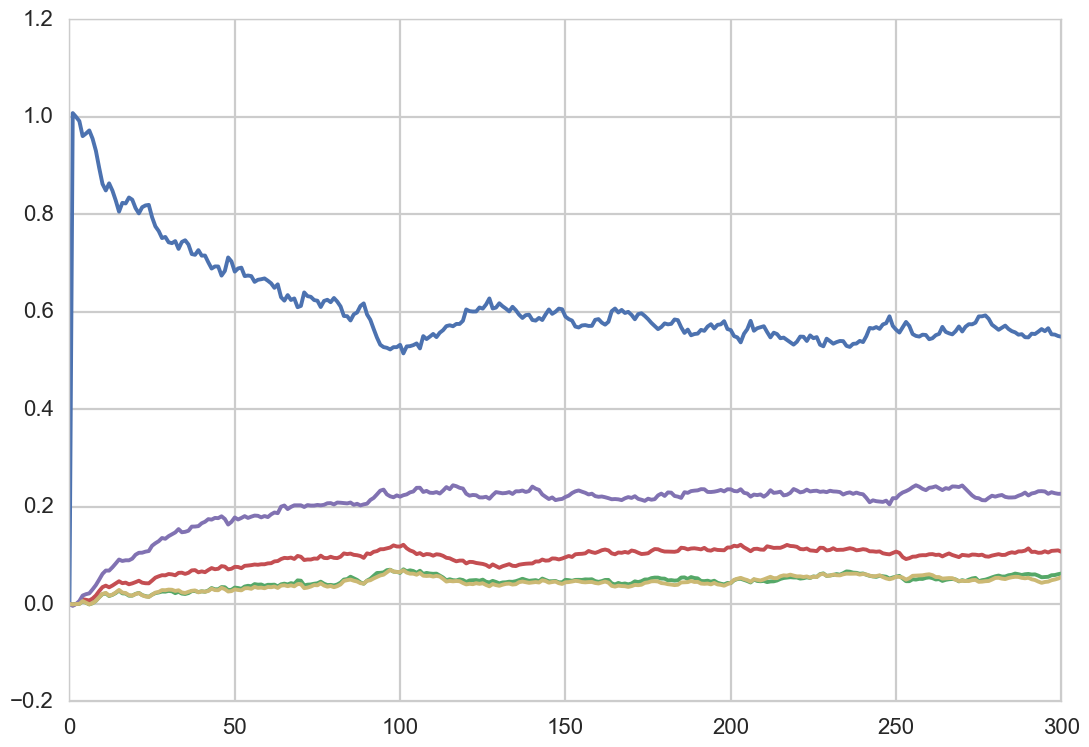

In [767]:
for i in range(5):
    
    plt.plot(bkwd_params["Xn"][0:,i])

## Baum-Welsh Update

In [768]:
def OneLagUpdate(P_n_t_tmin1, t, Ps, Jn, Phi):
    
    P_n_tmin1_tmin2 = Ps[t-1].dot(Jn[t-2].T) + Jn[t-1].dot(P_n_t_tmin1 - Phi.dot(Ps[t-1])).dot(Jn[t-2].T)
        
    return P_n_tmin1_tmin2
        
def OneLagCovarianceSmoother(fwd_params, bkwd_params):
    
    n = len(fwd_params["Xs"])
    K = len(fwd_params["Xs"][0])
    
    Kn = fwd_params['Kn']
    P_n_n_nmin1 = (np.eye(K) - Kn.dot(A)).dot(Phi).dot(bkwd_params["Pn"][-2])
    
    P_one_lag = np.zeros((n, P_n_n_nmin1.shape[0], P_n_n_nmin1.shape[1]))
    P_one_lag[-1] = P_n_n_nmin1
    
    Ps = fwd_params['Ps']
    Jn = bkwd_params['Jn']
    
    for t in range(n-1, 1, -1):
        
        P_n_tmin1_tmin2 = OneLagUpdate(P_n_n_nmin1, t, Ps, Jn, Phi)
        P_one_lag[t] = P_n_tmin1_tmin2
        
    return P_one_lag

In [780]:
def MaximisationUpdate(ys, fwd_params, bkwd_params):
    
    Pn = bkwd_params['Pn']
    Xn = bkwd_params['Xn']
    Pn_one_lag = OneLagCovarianceSmoother(fwd_params, bkwd_params)
    
    n = len(Xs)
    start = 2
    end = n
    
    S_1_0 = np.zeros_like(Ps[0])
    S_1_1 = np.zeros_like(Ps[0])
    S_0_0 = np.zeros_like(Ps[0])
    
    for (x_n_t, x_n_tmin1, P_n_t, P_n_tmin1, P_n_t_tmin1) in zip(Xn[start+1:end], 
                                                                Xn[start:end-1], 
                                                                Pn[start+1:end],
                                                                Pn[start:end-1],
                                                                Pn_one_lag[start:end-1]):
        
        x_n_t = x_n_t.reshape(-1,1)
        x_n_tmin1 = x_n_tmin1.reshape(-1,1)
        
        S_1_1 += x_n_t.dot(x_n_t.T) + P_n_t
        S_1_0 += x_n_t.dot(x_n_tmin1.T) + P_n_t_tmin1 #TODO this one is wrong
        S_0_0 += x_n_tmin1.dot(x_n_tmin1.T) + P_n_tmin1
    
    S_0_0_inv = np.linalg.pinv(S_0_0)
    
    Phi_j = S_1_0.dot(S_0_0_inv)
    Q_j = 1/(n) * (S_1_1 - S_1_0.dot(S_0_0_inv).dot(S_1_0.T))
    
    for i, row in enumerate(Q_j):
        for j,_ in enumerate(row):
            if i != j:
                Q_j[i,j] = 0
    
    R_j = np.zeros_like(A.dot(A.T))
    for y, X, P in zip(ys[1:], Xn[1:], Pn[1:]):
        
        R_j += (y - A.dot(X)).dot((y - A.dot(X)).T) + A.dot(P).dot(A.T)
        
    R_j /= (n)
    
    eig = np.linalg.eig(Phi_real)[1][:,0]
    eig/np.sum(eig)

    return { "mu0": Xn[1], 
             "Sig0": Pn[1], 
             "Phi": Phi_j, 
             "Q": Q_j, 
             "R": R_j,
             "thetas": eig }               
    
def EM_step(ys, params):
    
    mu0 = params['mu0']
    Sig0 = params['Sig0']
    Phi = params['Phi']
    Q = params['Q']
    R = params['R']
    
    # Expectation Step (using Kalman Filter and Smoother)
    fwd_params = ForwardKalmanFilter(ys, mu0, Sig0, Phi, Q, R)
    bkwd_params = KalmanSmoother(fwd_params, Phi)
    
    # Maximisation Step (using update equation that was derived in [1])
    update_params = MaximisationUpdate(ys, fwd_params, bkwd_params)
    
    return update_params, fwd_params['incomplete_likelihood']

def ExpectationMaximisation(ys, starting_params):
    
    num_iter = 50
    
    params = starting_params
    lklihoods = np.zeros(num_iter)
    
    for i in range(num_iter):
        
        params_new, likelihood = EM_step(ys, params)

        params['Phi'] = params_new['Phi']
        params['mu0'] = params_new['mu0']
        params['Sig0'] = params_new['Sig0']
        params['Q'] = params_new['Q']
        
        lklihoods[i] = likelihood
        
    return params, lklihoods

In [781]:
result = MaximisationUpdate(ys, fwd_params, bkwd_params)

# Test the EM algorithm

In [782]:
mu0 = np.array([1,0,0,0,0])
Sig0 = np.eye(5)*1e-1

Phi = np.eye(5)

Q = np.eye(5)*1e-1
R = np.eye(5)*1e-8

params = { "mu0": mu0, 
           "Sig0": Sig0, 
           "Phi": Phi, 
           "Q": Q, 
           "R": R } 

In [783]:
result_params, lk = ExpectationMaximisation(ys, params)

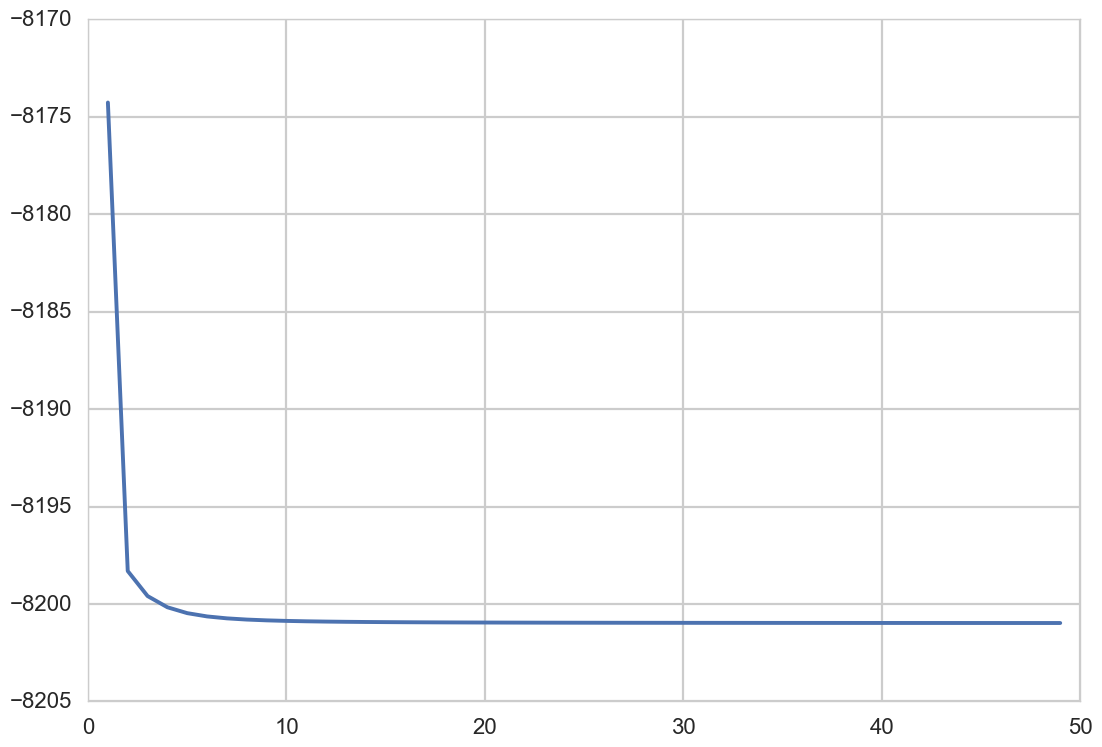

In [784]:
plt.plot(lk)

In [785]:
result_params

{'Phi': array([[  9.86756095e-01,   2.23778628e-01,  -5.42968611e-02,
           1.11972408e-02,  -2.11457398e-02],
        [  1.05582157e-03,   8.85761872e-01,   1.91881585e-02,
           8.21285528e-03,   3.11733590e-02],
        [  3.03575153e-03,  -6.01897832e-02,   9.87776376e-01,
           1.27248986e-02,  -4.23427222e-03],
        [  7.99592360e-03,  -3.79648868e-04,   3.02625709e-02,
           9.61688136e-01,   1.98763351e-02],
        [  1.15650100e-03,  -4.86265868e-02,   1.70976387e-02,
           6.10651788e-03,   9.74232962e-01]]),
 'Q': array([[  9.07464037e-05,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   7.81823691e-06,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   8.31713031e-06,
           0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           1.59857837e-05,   0.00000000e+00],
     

# Look at the largest Eigen Vector of the Learnt Matrix

In [786]:
eig = np.linalg.eig(result_params['Phi'])[1][:,0].real
eig/np.sum(eig)

array([ 0.57092708,  0.05209042,  0.102819  ,  0.22523792,  0.04892558])

In [787]:
np.linalg.eig(Phi_real)[1][:,0].real
eig/np.sum(eig)

array([ 0.57092708,  0.05209042,  0.102819  ,  0.22523792,  0.04892558])

Notice that these normalised eigen vectors are very similar

In [788]:
water = [np.array([1,0,0,0,0])]
N = 5
timesteps = np.arange(1,5*60)
A = np.eye(5)

Phi = result_params['Phi']
Phi = Phi/np.sum(Phi, axis=0) 

for i in timesteps:
    
    delta = Phi
    delta = delta/np.sum(delta, axis=0)       
    water.append(A.dot(delta.dot(water[i-1])))
    
water = np.array(water)

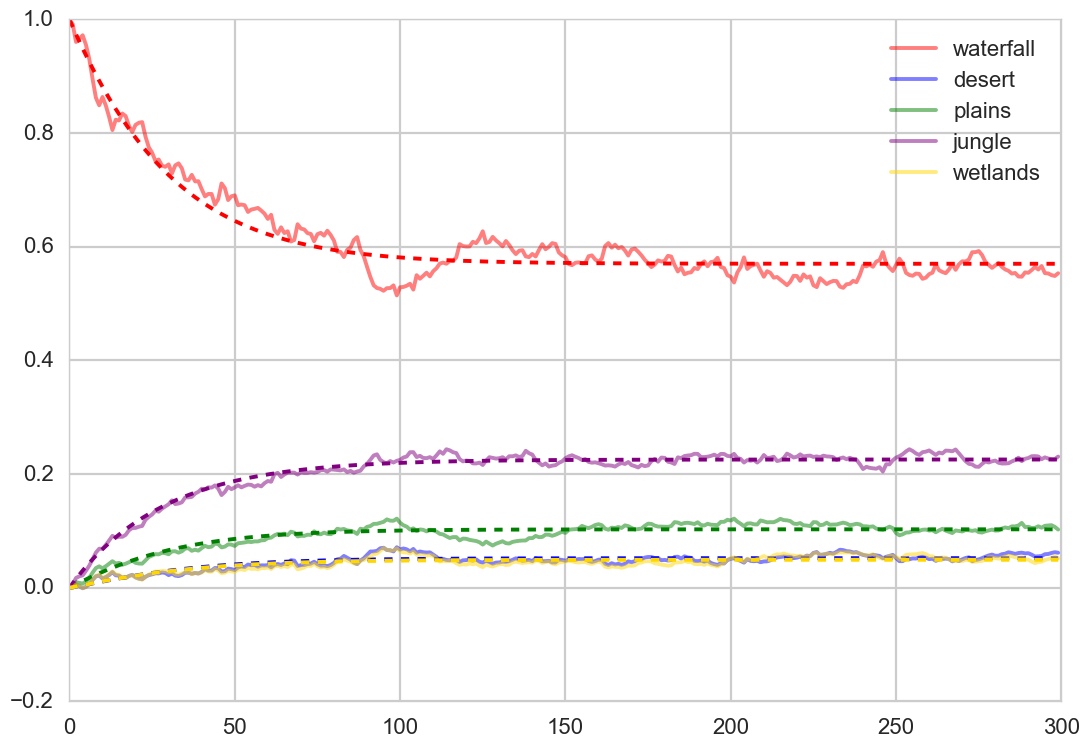

In [789]:
fig, ax = plt.subplots(1,1)

c = ['r', 'b', 'g', 'purple', 'gold']
labels=['waterfall', 'desert', 'plains', 'jungle', 'wetlands']
for i in range(len(water[0])):
    ax.plot(water[:,i], c=c[i], ls='--')
    ax.plot(water_sim[:,i], label=labels[i], c=c[i], alpha=0.5)

plt.legend(loc='best')
plt.show()